# VinBigData Chest X-ray Abnormalities Detection competition

As the [competition overview](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/overview) describes (if you did not read it, read it - including the linked materials they provide!), the goal in this competition is to localize and classify 14 types of chest abnormalities on images (chest radiographs). For that, we are given 15,000 labeled images (with labels provided by 3 separate radiologists that can - **and will** - disagree) as training data. The test data is 3,000 images and these were labelled based on the **consensus** of 5 radiologists. Thus, the training data we are given is not actually labelled in the way the test data were labelled.

## Table of contents
1. [Labelling process that created the training and test data](#1)
2. [First part of the data: train.csv](#2)
3. [Second part of the data: .dicom image files](#3)
4. [Where do the different findings tend to be?](#4)
5. [How big do bounding boxes tend to be for different classes? How many are there?](#5)
6. [What is in the .dicom meta-data?](#6)
7. [Creating fast to read shelve file](#new7) 
8. [Example images of each class](#8new)
9. [Some thoughts on cross-validation](#7)
10. [Some initial thoughts on data augmentation](#8)
11. [Implementing augmentations with bounding boxes](#9)
12. [Possible data issues](#11a)
13. [What are we asked to predict, exactly?](#10)

The data comes in two parts: 1. a train.csv file and 2. .dicom image files, so one key part of what we'll look at is what these files contain. A lot of the EDA is also looking at data across the files (e.g. showing bounding boxes on the images, looking at what areas findings tend to be in). I will also look at some more modeling related questions such as cross-validation, data augmentation and the expected modeling output.

Another important thing is how we read the data fast during model training. I have a suggestion using `shelve` (like pickle, but allows parallel reading and access via dictionary keys).

But, first, let's talk about how the labels were created.

<a id="1"></a>
# 1. Labelling process that created the training and test data

Given that the data generating process is often rather important for deciding on cross-validation and other modeling decisions, one should definitely read [the paper](https://storage.googleapis.com/kaggle-media/competitions/VinBigData/VinDr_CXR_data_paper.pdf) that provides details on how the dataset was buildt - in fact, the EDA they do in there is pretty good as a starting point (and it's one of the better examples of explaining the competition data clearly that I've seen on Kaggle). Figure 1 of the paper shows this data flow:
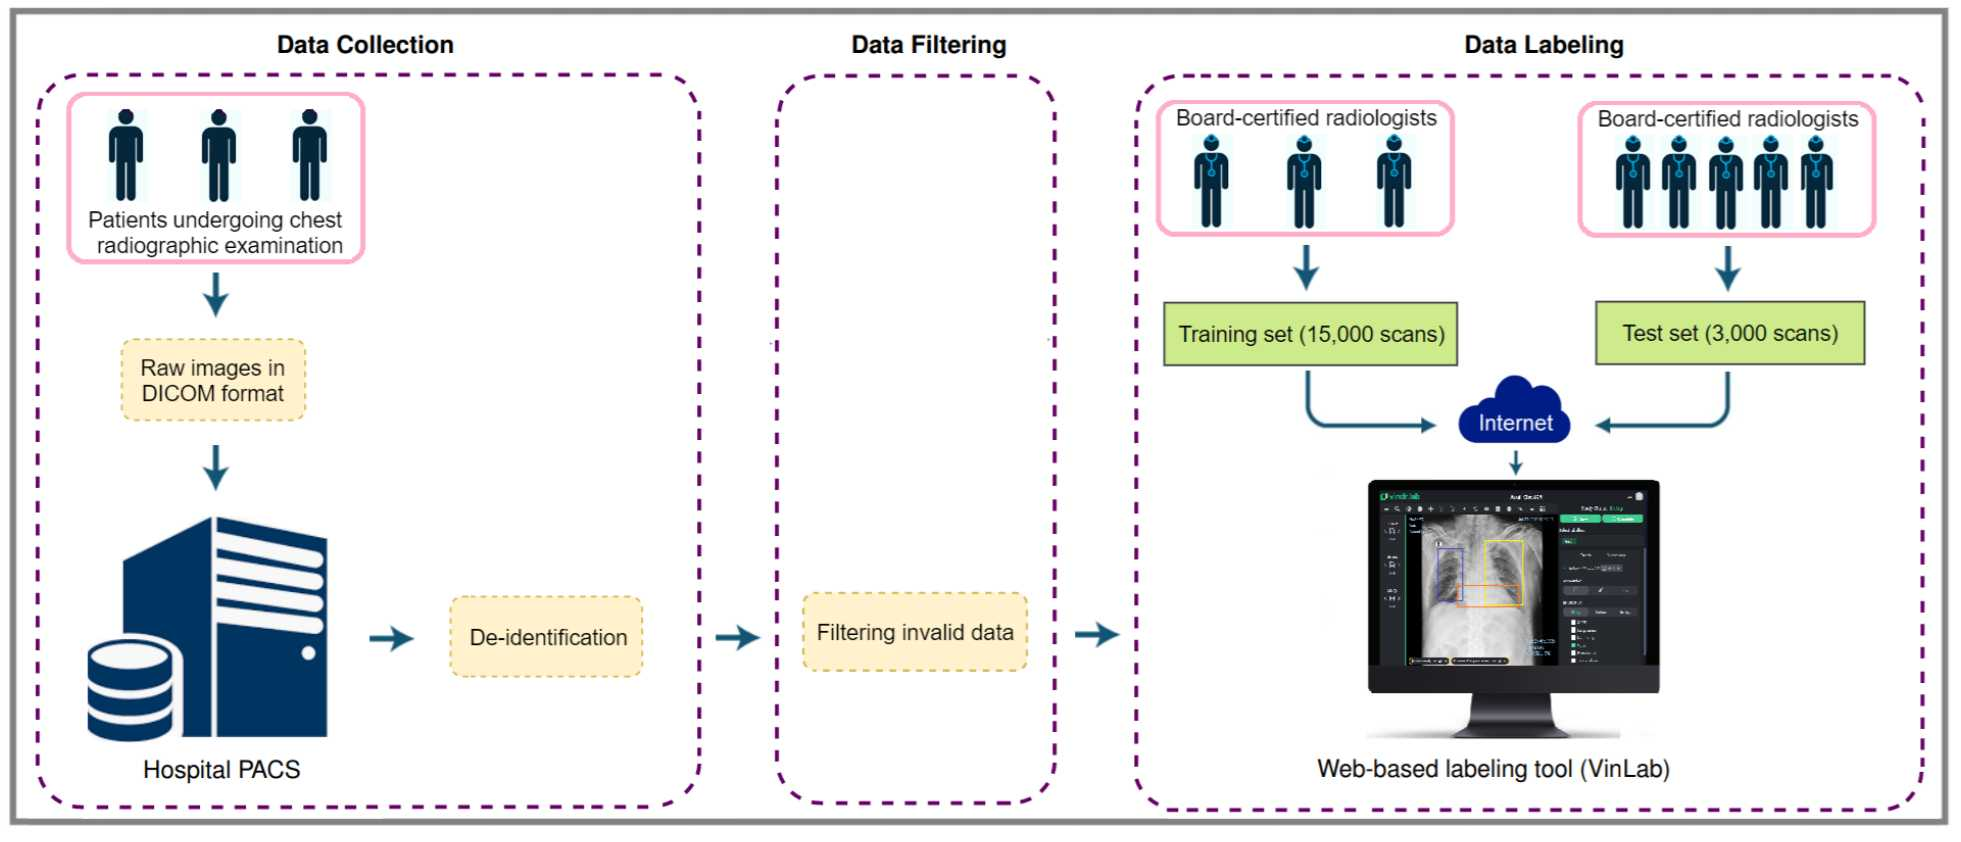

Note that the paper describes for the test data that:
> For the test set, 5 radiologists involved into a two-stage labeling process. During the first stage, each image was independently annotated by 3 radiologists. In the second stage, 2 other radiologists, who have a higher level of experience, reviewed the annotations of the 3 previous annotators and communicated with each other in order to decide the final labels. The disagreements among initial annotators were carefully discussed and resolved by the 2 reviewers. Finally, the consensus of their opinions will serve as reference ground-truth.

This single final consensus is what we are evaluated against on the test set. In a way, the second stage of the test set labelling is missing / was not done for the training data.


## Looking in more detail at the radiologist performance
This interesting [discussion](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/215444) in the forums prompted me to look a bit more into the details of how the 17 different radiologists performed the scoring. The question is - since we have annotations by three different radiologists and no single ground-truth - how do we combine these annotations? Ideas include using all annotations in turn/different ones in different epochs of training and somehow combining them to imitate the consensus process. For the latter part, it would be interesting, if we could account for the skill of the radiologists. Perhaps some radiologist even tend to make particular mistakes (whether those are misinterpretations or software usage issues that keep happening to the same person).

When we look at how much class 14 (="no finding"; see below for explanation of classes) gets assigned at an image level (rather than at a bounding box level), it looks to me like some X-rays were a-priori believed to be without a finding (= `class_id` 14) and those were predominantly assigned to certain radiologists, especially `R1` to `R7`. On the other hand, `R8`, `R9` and `R10` mostly did get images with findings. However, we can see that the other radiologists `R11` to `R17` also reviewed quite a few "no findings" images. Of course, there seems to have been some mixing up of who reviews together. When they co-reviewed, everyone seems to mostly agree on those "no findings" cases. None of this is mentioned in the paper - especially how the prescreening for "a-priori no findins" images worked.

In [ ]:
import numpy as np
import pandas as pd
train = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')

whatassigned = train[['rad_id', 'class_id', 'image_id']]\
    .groupby(['rad_id', 'class_id'])\
    .count()\
    .reset_index()\
    .pivot(index='rad_id', columns='class_id',values='image_id')\
    .add_prefix('class')\
    .fillna(0)\
    .astype(np.int64)
whatassigned['Percent with no finding'] = [f'{tmpvar}%' for tmpvar in np.round(100*whatassigned['class14'].values/whatassigned.sum(axis=1).values,2)]
whatassigned

When we look at how much radiologists agree with each other, we immediately see that some have fantastic agreement with their peers, **but** that's primarily those radiologists that soely (or mostly) reviewed the cases with no findings. So, it's difficult to see how much we should read into this.

In [ ]:
rad_id_counts = (train.assign(counter=1))[['rad_id', 'image_id', 'class_id', 'counter']]\
    .drop_duplicates()\
    .pivot(index=['rad_id', 'image_id'], columns='class_id', values='counter')\
    .add_prefix('class')\
    .fillna(0)\
    .astype(np.int8)\
    .reset_index()  

rename_dict = {'rad_id': 'rad_id2'}
rename_dict.update({f'class{class_id}': f'class{class_id}_2' for class_id in range(15)})
merge1 = pd.merge( rad_id_counts,
                   rad_id_counts.rename(columns=rename_dict),
                  on='image_id', how='outer' )
merge1 = merge1[merge1['rad_id'] != merge1['rad_id2']]

rename_dict = {'rad_id': 'rad_id3'}
rename_dict.update({f'class{class_id}': f'class{class_id}_3' for class_id in range(15)})
merge2 = pd.merge( merge1,
                  rad_id_counts.rename(columns=rename_dict),
                  on='image_id', how='outer')
merge2 = merge2[ (merge2['rad_id'] != merge2['rad_id3']) & (merge2['rad_id2'] != merge2['rad_id3'])]

for class_id in range(15):
    merge2[f'Agreed with both colleagues on class {class_id}'] = (merge2[f'class{class_id}']==merge2[f'class{class_id}_2']) & (merge2[f'class{class_id}']==merge2[f'class{class_id}_3'])
    merge2[f'Agreed with one colleague on class {class_id}'] = (merge2[f'class{class_id}']==merge2[f'class{class_id}_2']) | (merge2[f'class{class_id}']==merge2[f'class{class_id}_3'])

class_agree_both_cols = [f'Agreed with both colleagues on class {class_id}' for class_id in range(15)]
merge2[f'Agreed with both colleagues on all classes'] = merge2[class_agree_both_cols].min(axis=1)
class_agree_one_cols = [f'Agreed with one colleague on class {class_id}' for class_id in range(15)]
merge2[f'Agreed with at least on colleague on all classes'] = merge2[class_agree_one_cols].min(axis=1)

for class_id in range(15):
    merge2[f'When proposing class {class_id} both colleagues agree'] = np.where(merge2[f'class{class_id}']==1,
                                                                                (merge2[f'class{class_id}']==merge2[f'class{class_id}_2']) & (merge2[f'class{class_id}']==merge2[f'class{class_id}_3']), 
                                                                                pd.NA)
    merge2[f'When proposing class {class_id} at least one colleague agrees'] = np.where(merge2[f'class{class_id}']==1, 
                                                                                        (merge2[f'class{class_id}']==merge2[f'class{class_id}_2']) | (merge2[f'class{class_id}']==merge2[f'class{class_id}_3']), 
                                                                                        pd.NA)

class_agree_both_cols = [f'When proposing class {class_id} both colleagues agree' for class_id in range(15)]
merge2[f'When proposing classes for record both colleagues agree'] = merge2[class_agree_both_cols].min(axis=1)
class_agree_one_cols = [f'When proposing class {class_id} at least one colleague agrees' for class_id in range(15)]
merge2[f'When proposing classes for record at least one colleague agrees'] = merge2[class_agree_one_cols].min(axis=1)
#print(merge2[f'When proposing classes for record both colleagues agree'].mean())
#print(merge2[f'When proposing classes for record at least one colleague agrees'].mean())


for colname in list(merge2.columns[-66:]):
    merge2[colname] = 1.0*merge2[colname]
summary_cols = ['rad_id'] + list(merge2.columns[-64:])

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

howmany = merge2[['rad_id', 'image_id']]\
    .groupby('rad_id')\
    .count()\
    .rename(columns={'image_id':'Images assessed'})\
    .reset_index()\
    .assign(Metric='Images assessed')\
    .pivot(index='Metric', columns='rad_id', values='Images assessed')\
    .reset_index()

tmp1 = merge2[summary_cols]\
    .melt(id_vars='rad_id', var_name='Metric', value_name='Value')
 # = tmp1['Value'].astype(float)
tmp1['Value'] = pd.to_numeric(tmp1['Value'], errors='coerce') #.value_counts(dropna=False)
tmp1 = tmp1\
    .groupby(['rad_id', 'Metric'])\
    .mean()\
    .reset_index()\
    .pivot(index='Metric', columns='rad_id', values='Value')\
    .reset_index()

pd.concat([howmany, tmp1])[ ['Metric'] + [f'R{rad_id}' for rad_id in range(1,18)] ]

In [ ]:
import os
import re
import pandas as pd
from fastai.medical.imaging import *
from fastai.vision.all import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
from tqdm import tqdm # for getting a progress bar on loops

<a id="2"></a>
# 2. First part of the data: train.csv

The `train.csv` file gives the outcomes of the review of each image (unique ID is `image_id`) by 3 radiologists (unique ID `rad_id`). And all classes the radiologist has assigned per image. Each class (`class_id` matching up to `class_name`) for an image is in a separate record. So, in case of a `No finding` or a single finding, there would be just one recod for the combination of `image_id` and `rad_id`, in case of multiple findings there would be multiple records. In addition there is a bounding box given for where the finding is on the image, which is indicated in terms of a rectangle given by a minimum x (`x_min`), maximum x (`x_max`), minimum y (`y_min`) and maximum y (`y_max`) values. When there is no finding, these coordinates are `NaN`.

In [ ]:
train = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
train.head()

In the data we have the following classes (the supplementary material of the paper describing the competition data explaines the medical definiton of the classes) with the following `class_id` values from 0 to 14:

In [ ]:
train[['class_id', 'class_name', 'rad_id']].groupby(['class_id', 'class_name']).count().rename(columns={'rad_id': 'Number of records'})

So, what do these categories mean? This is actually explained in the [paper linked on the competition homepage](https://arxiv.org/pdf/2012.15029.pdf):
0. **Aortic enlargement**: "An abnormal bulge that occurs in the wall of the major blood vessel."
1. **Atelectasis**: "Collapse of a part of the lung due to a decrease in the amount of air in the alveoli resulting in volume loss and increased density." (see also [Merck Manual](https://www.merckmanuals.com/professional/pulmonary-disorders/bronchiectasis-and-atelectasis/atelectasis?query=Atelectasis))
2. **Calcification**: "Deposition of calcium salts in the lung." - one article I looked at says that "\[...\] calcifications occur in a damaged lung following an inflammatory process such as infection (tuberculosis, histoplasmosis, Pneumocystis carnii), bleeding or pulmonary infarction" ([Bendayan et al. 2000](https://dx.doi.org/10.1053/rmed.1999.0716))
3. **Cardiomegaly**: "Enlargement of the heart, occurs when the heart of an adult patient is larger than normal and the cardiothoracic ratio is greater than 0.5."
4. **Consolidation**: "Any pathologic process that fills the alveoli with fluid, pus, blood, cells (including tumor cells) or other substances resulting in lobar, diffuse or multifocal ill-defined opacities."
5. **ILD**: "Interstitial lung disease (ILD) Involvement of the supporting tissue of the lung parenchyma resulting in fine or coarse reticular opacities or small nodules." (see also [Merck Manual](https://www.merckmanuals.com/professional/pulmonary-disorders/interstitial-lung-diseases/overview-of-interstitial-lung-disease?query=interstitial%20lung%20disease))
6. **Infiltration**: "An abnormal substance that accumulates gradually within cells or body tissues or any substance or type of cell that occurs within or spreads as through the interstices (interstitium and/or alveoli) of the lung, that is foreign to the lung, or that accumulates in greater than normal quantity within it."
7. **Lung Opacity**: "Any abnormal focal or generalized opacity or opacities in lung fields (blanket tag including but not limited to consolidation, cavity, fibrosis, nodule, mass, calcification, interstitial thickening, etc.)." (much more detail in this [Kaggle notebook](https://www.kaggle.com/zahaviguy/what-are-lung-opacities))
8. **Nodule/Mass**: "Any space occupying lesion either solitary or multiple."
9. **Other lesion**: "Other lesions that are not on the list of findings or abnormalities mentioned above."
10. **Pleural effusion**: "Abnormal accumulations of fluid within the pleural space." (see also [Merck Manual](https://www.merckmanuals.com/professional/pulmonary-disorders/mediastinal-and-pleural-disorders/pleural-effusion?query=Pleural%20effusion))
11. **Pleural thickening**: "Any form of thickening involving either the parietal or visceral pleura." (see also [Radiopaedia](https://radiopaedia.org/articles/pleural-thickening))
12. **Pneumothorax**: "The presence of gas (air) in the pleural space." (see also the [Merck Manual](https://www.merckmanuals.com/professional/pulmonary-disorders/mediastinal-and-pleural-disorders/pneumothorax?query=Pneumothorax))
13. **Pulmonary fibrosis**: "An excess of fibrotic tissue in the lung."
14. **No finding**: Kind of self-explanatory (there were no findings).

I have added example images of each class later on in Section [Example images of each class](#8new).

How is the occurence of the different classes correlated? Unsurprisingly, no finding is negatively correlated with all findings, while the various findings are slightly positively correlated, except for a few exceptions with strong correlations such as '0: Aortic enlargement' and '3: Cardiomegaly'.

In [ ]:
tmpdf = train[['class_id', 'image_id', 'rad_id']].groupby(['class_id', 'image_id']).count().reset_index()
tmpdf['rad_id'] = np.minimum(tmpdf['rad_id'].values, 1)
corr  = tmpdf.pivot(index='image_id', columns='class_id', values='rad_id').fillna(0).reset_index(drop=True).corr()
corr.style.background_gradient(cmap='coolwarm', vmin=-1.0, vmax=1.0).set_precision(2)

In [ ]:
records = len(train)
unique_images = len(np.unique(train.image_id))

min_records = np.min( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )
mean_records = np.mean( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )
median_records = np.median( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )
max_records = np.max( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )

print(f'There are {records} records and {unique_images} images as per image_id.')
print(f'The number of records per image is a mean of {mean_records} (median {median_records}) with a minimum of {min_records} and a maximum of {max_records}')

dedup = train[['image_id', 'rad_id']].drop_duplicates()

min_records = np.min( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )
mean_records = np.mean( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )
median_records = np.median( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )
max_records = np.max( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )

print(f'The number of radiologists (rad_id) per is exactly 3 (minimum of {min_records} and a maximum of {max_records}).')


Let's look at the records for one image with 3 records in the `train.csv` file:

In [ ]:
train[train['image_id']=='000434271f63a053c4128a0ba6352c7f']

Now, let's see some records for the image with 57 records:

In [ ]:
train[train['image_id']=='03e6ecfa6f6fb33dfeac6ca4f9b459c9']

<a id="3"></a>
# 3. Second part of the data: .dicom image files

I use the [fastai medical imaging tools](https://docs.fast.ai/medical.imaging.html#Path.dcmread) (note there's also a nice [tutorial by Jeremy Howard on dicom gotchas](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai)), but that uses [pydicom](https://pydicom.github.io/) in the background, which is another library you could use. A recent competition with .dicom files was [OSIC Pulmonary Fibrosis Progression](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression), but there have been several others, so these might be worth checking out for the notebooks and ideas for image processing that were shared.

So, what's in a [.dicom](http://) file? Let's take a look. We'll use an image that has some abnormalities:

In [ ]:
train[train['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345']

In [ ]:
TEST_DCM = Path('../input/vinbigdata-chest-xray-abnormalities-detection/train/9a5094b2563a1ef3ff50dc5c7ff71345.dicom')
dcm = TEST_DCM.dcmread()
dcm

In [ ]:
dcm.show();

Note that there's one single channel in these images (monochrome), so they will not easily work with neural networks pre-trained with multiple color channels. However, fastai has a [helper function](https://docs.fast.ai/medical.imaging.html#Tensor.to_3chan) that returns a version with 3 (or a different number of channels). Even if you do not want to use the library, you can always look at the source code of the function and see what helps you. Also, in the augmentations section later, I show another way of achieving the same thing.

In [ ]:
plt.figure(figsize=(16, 28));
fig,ax = plt.subplots(1);

ax.imshow(dcm.pixels, cmap='gray');
rect1 = ptc.Rectangle((691,1375),1653-691, 1831-1375,linewidth=1,edgecolor='r',facecolor='none'); # (x, y), width, height
ax.add_patch(rect1);

rect2 = ptc.Rectangle((1789,1729),1875-1789, 1992-1729,linewidth=1,edgecolor='b',facecolor='none'); # (x, y), width, height
ax.add_patch(rect2);
rect3 = ptc.Rectangle((692, 1375), 1657-692, 1799-1375,linewidth=1,edgecolor='b',facecolor='none'); # (x, y), width, height
ax.add_patch(rect3);
rect4 = ptc.Rectangle((1052,715),1299-1052, 966-715,linewidth=1,edgecolor='b',facecolor='none'); # (x, y), width, height
ax.add_patch(rect4);

rect5 = ptc.Rectangle((689,1313),1666-689, 1763-1313,linewidth=1,edgecolor='g',facecolor='none'); # (x, y), width, height
ax.add_patch(rect5);

plt.show();

As we can see, the 3 radiologists (I used a different color for each radiologist) roughly agreed on one area of interest and they all said there was `Cardiomegaly`, but there were two other areas only highlighted by one of the radiologists. Additionally, the one that highlighted the extra areas, also gave two separate labels to the central area that everyone higlighted.

So, clearly, we are dealing with label noise here.

As we can see from  [the paper](https://storage.googleapis.com/kaggle-media/competitions/VinBigData/VinDr_CXR_data_paper.pdf) sponsors wrote, the test set labels are based on the consensus of 5 radiologists. Without a lot of subject matter expertise, it's of course rather hard to guess what the consensus of radiologists would be after each coming up with the slightly disagreeing labels and bounding boxes.

I have to admit, the plots they made in the paper such as Figure 3
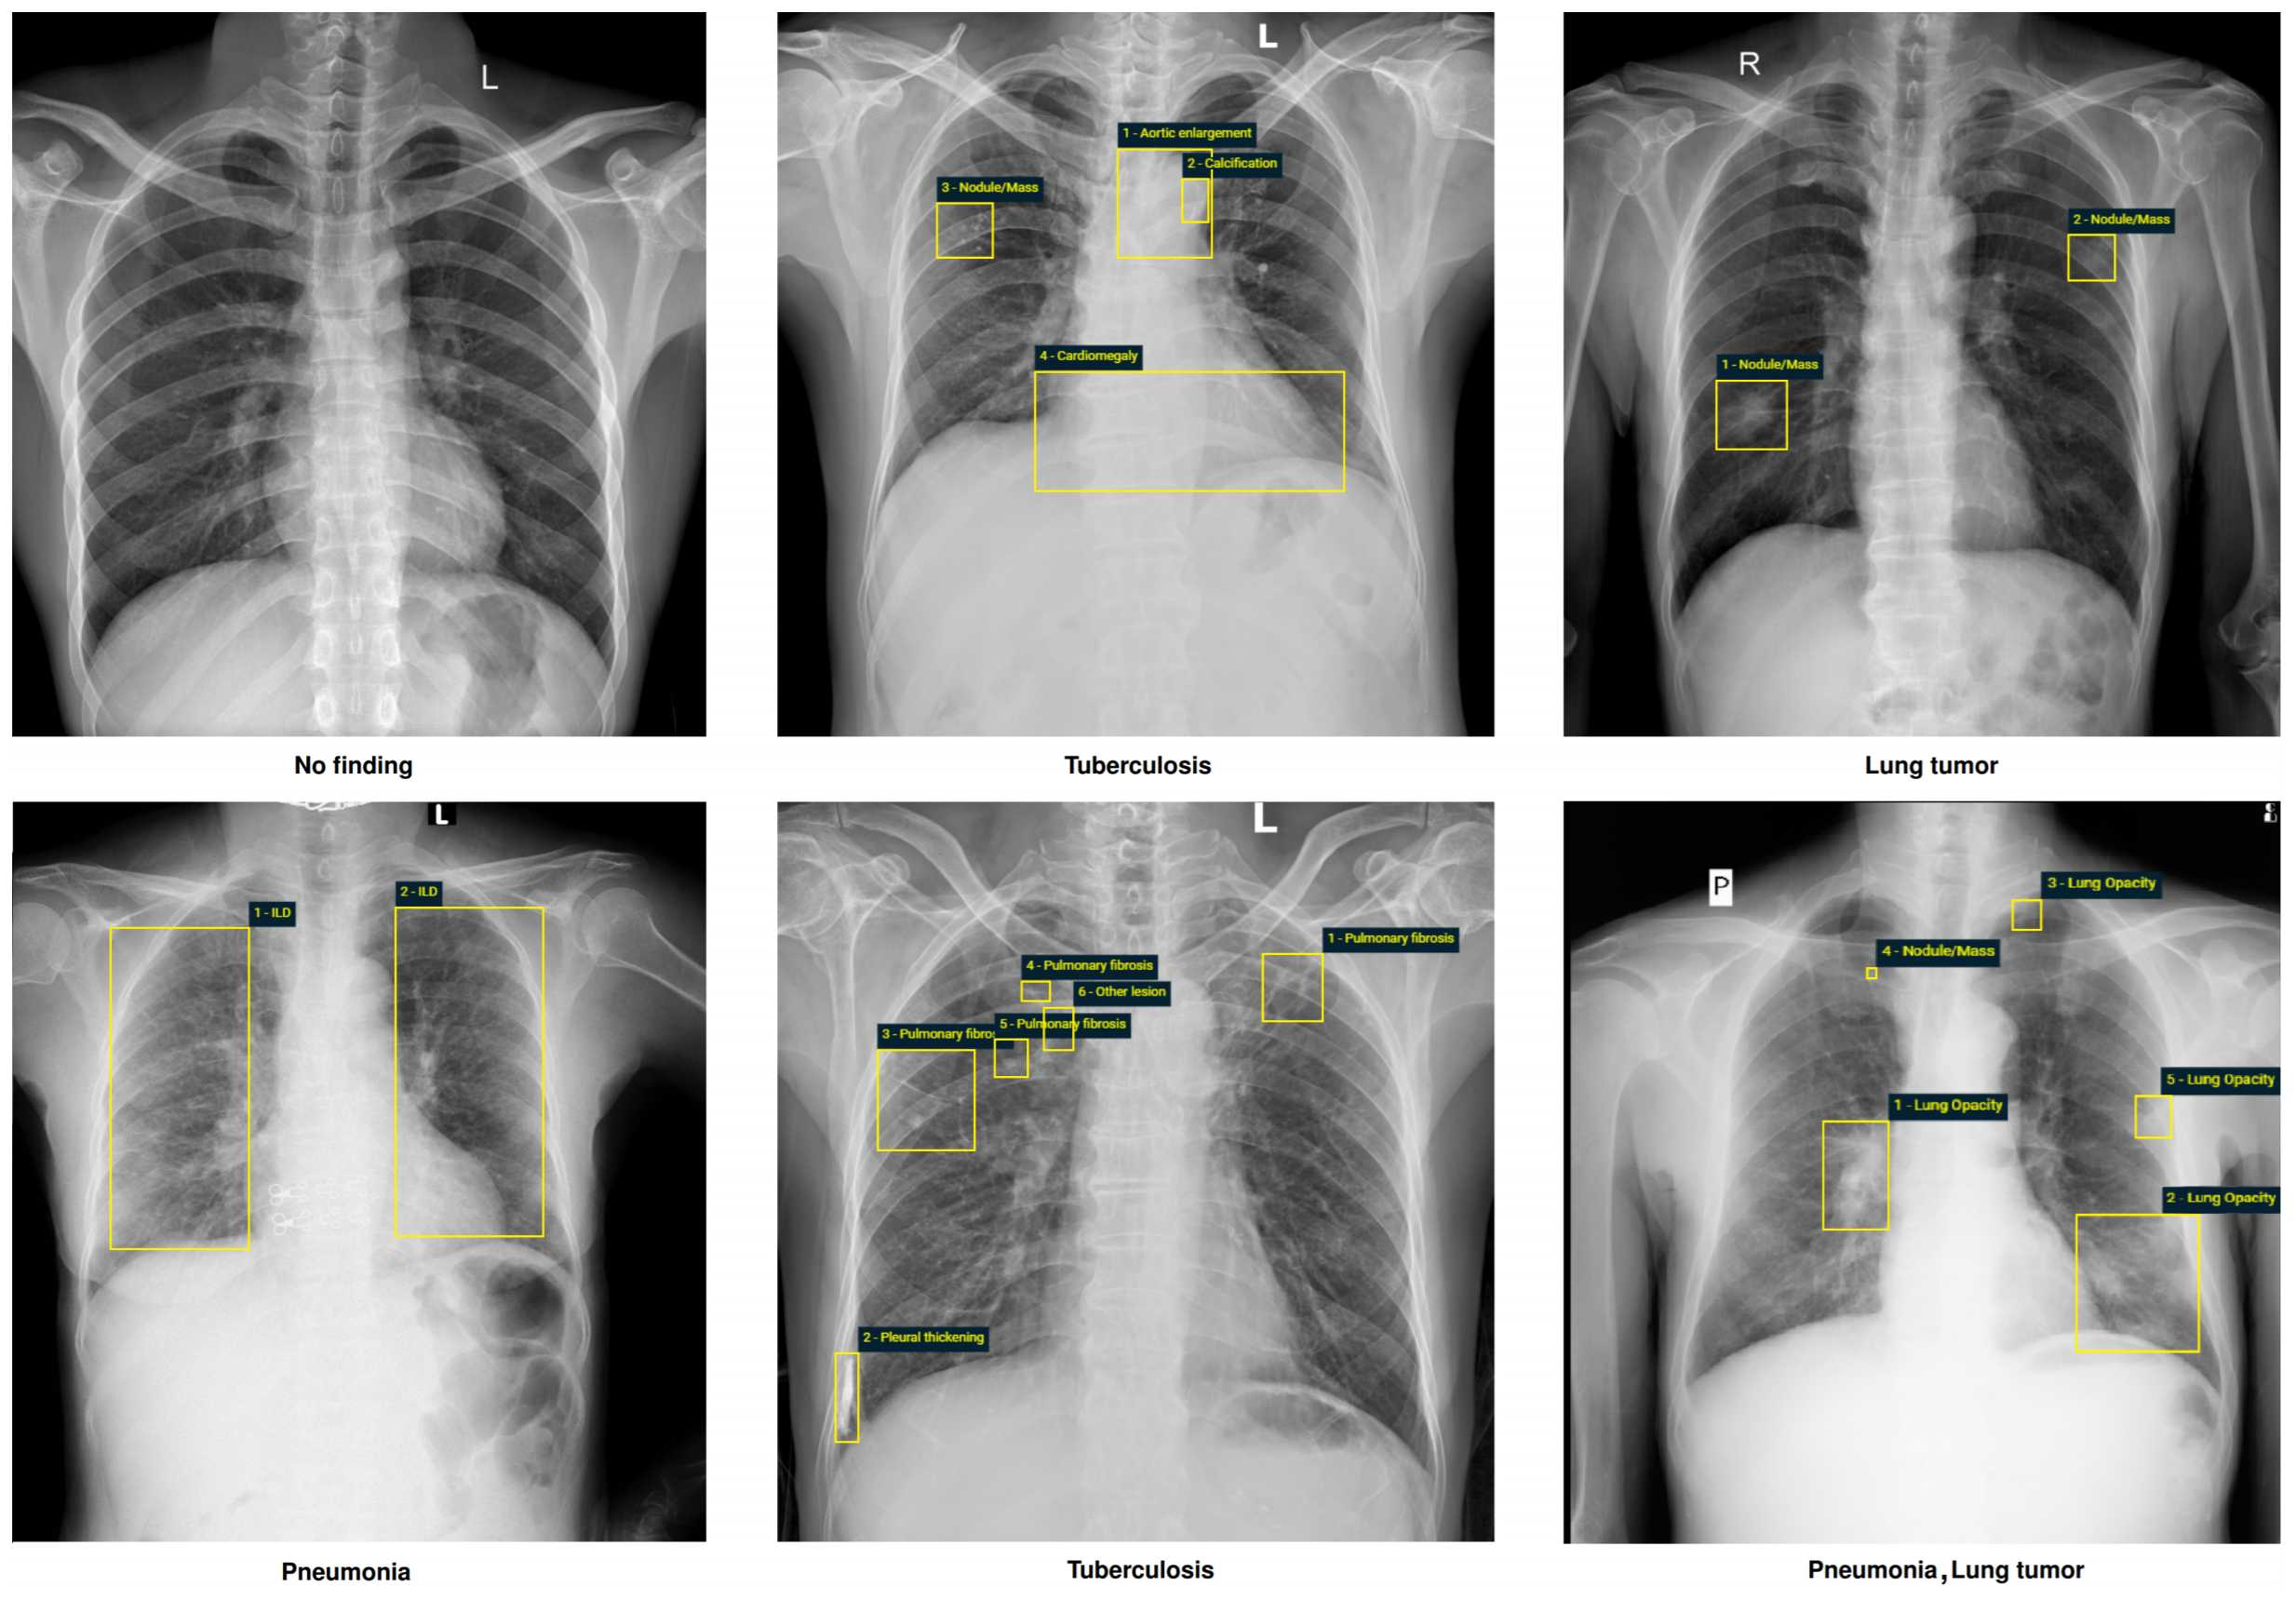
are really nice and very nicely annotated.

<a id="4"></a>
# 4. Where do the different findings tend to be?

As we can see below, certain findings tend to concentrate in certain area - we'll ignore that images might not all be the same size. E.g. aortic enlargment is where the aorta is, cardiomegaly is around the heart, etc., which may be useful for checking the plausibility of model outputs/knowledge we might try to explicitly provide to networks (that of course assumes that all images show upper bodies from a similar distance).

In [ ]:
locations = np.zeros((14, int(np.ceil(np.max(train.y_max)/10)*10), int(np.ceil(np.max(train.x_max)/10)*10)))
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    if row['class_id']<14:
        locations[row['class_id'], int(row['y_min']):int(row['y_max']+1), int(row['x_min']):int(row['x_max']+1)] += 1

In [ ]:
classes = train[['class_id', 'class_name', 'rad_id']].groupby(['class_id', 'class_name']).count().rename(columns={'rad_id': 'Number of records'}).reset_index()

for index, row in classes.iterrows():
    if index==0:
        label_dict = {row['class_id']: row['class_name']}
    else:
        label_dict.update({row['class_id']: row['class_name']})

In [ ]:
f, axs = plt.subplots(5, 3, sharey=True, sharex=True, figsize=(16,28));

for class_id in range(14):
    axs[class_id // 3, class_id - 3*(class_id // 3)].imshow(locations[class_id], cmap='inferno', interpolation='nearest');
    axs[class_id // 3, class_id - 3*(class_id // 3)].set_title(str(class_id) + ': ' + label_dict[class_id])
    
plt.show();

<a id="5"></a>
# 5. How big do bounding boxes tend to be for different classes? How many are there?

Let's first look at the total area of each box for a class:

In [ ]:
cols = ['#e41a1c', '#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000000', '#1b9e77', '#d95f02', '#7570b3', '#e7298a']

In [ ]:
train['size'] = (train['x_max']-train['x_min'])*(train['y_max']-train['y_min'])
sizes = train.loc[train['class_id']<14, ['class_id', 'size']].groupby('class_id').mean().reset_index()

plt.figure(figsize=(16, 8));
plt.bar(sizes['class_id'], sizes['size'], 
        tick_label=[str(i) + ': ' + label_dict[i] for i in range(14)],
        color=cols);
plt.xticks(rotation='vertical');

Now total area for a class in an image (i.e. before we looked how large an average bounding box for a class is, here we look at the summed area of the bounding boxes within a class within an image):

In [ ]:
sizes2 = train.loc[train['class_id']<14, ['image_id', 'rad_id', 'class_id', 'size']].groupby(['image_id', 'rad_id', 'class_id']).sum('size').reset_index().groupby('class_id').mean('size').reset_index()

plt.figure(figsize=(16, 8));
plt.bar(sizes2['class_id'], sizes2['size'], tick_label=[str(i) + ': ' + label_dict[i] for i in range(14)],color=cols);
plt.xticks(rotation='vertical');

Finally, how many bounding boxes does a radiologist typically draw when he or she has identified a particular class in an image? As we can see certain classes (rather logically) typicall just have one bounding box, like e.g. "0: Aortic enlargement" or "3: Cardiomegaly", while others like "8: NoduleMass" tend to have more.

In [ ]:
numbers = train.loc[train['class_id']<14, ['image_id', 'rad_id', 'class_id', 'size']].groupby(['image_id', 'rad_id', 'class_id']).count().reset_index().groupby('class_id').mean('size').reset_index()

plt.figure(figsize=(16, 8));
plt.bar(numbers['class_id'], numbers['size'], tick_label=[str(i) + ': ' + label_dict[i] for i in range(14)], color=cols);
plt.xticks(rotation='vertical');

Let's have a closer look at which categories have more than one bounding box per radiologist. That's an [important question](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211035) when you start to consolidate the bounding boxes from different annotators. I.e. should you for certain categories only ever create one bounding box? for aortic enlargement and cardiomegaly (plus, of course, for "No finding", you can only ever by definition have a single bounding box, but depending on how you train your model, you may not even have that one in the ground truth you give to your model), I'd say yes, for the other categories probably not.

In [ ]:
bygroup = train[['image_id', 'class_name', 'rad_id','class_id']].groupby(['image_id', 'class_name', 'rad_id']).count().reset_index()
bygroup[['class_name', 'class_id']].groupby(['class_name']).max().sort_values('class_id').rename(columns={'class_id':'Max. number of bounding boxes by one radiologist for an image'})

In [ ]:
bygroup[['class_name', 'class_id']].groupby(['class_name']).mean().sort_values('class_id').rename(columns={'class_id':'Mean number of boxes per radiologist (once at least one indicated for this class by that radiologist)'}).round(3)

<a id="6"></a>
# 6. What is in the .dicom meta-data?

Let's get the meta-data from the dicom files. To me it looks like there might be some value in age and sex, but everything else may not be so useful.

In [ ]:
train_path = '../input/vinbigdata-chest-xray-abnormalities-detection/train/'
files = [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]

In [ ]:
prog = re.compile('^[A-Z]*')

def get_dcm_contents(file):
    dcm = Path(train_path + file).dcmread()    
    properties = [string for string in dir(dcm) if prog.match(string).group(0)!='']
    dict1 = {'file': file.replace('.dicom', '')}    
    dict1.update( { what: dcm[what].value for what in properties if isinstance(dcm[what].value, (bytes, bytearray))!=True } )
    return dict1
    
train_files = pd.DataFrame( [ get_dcm_contents(file) for file in tqdm(files) ] )

Something to look at is also the aspect ratio. We can compare it to a 16:9 format that you may know for films - that's a aspect ratio of 1.777 or if you rotate it of 0.5625 - so we see that the average aspect ratio of 0.877 for the X-rays here is less extreme than that, but tends to be taller than wide.

In [ ]:
train_files['Aspect Ratio'] = train_files['Columns'] / train_files['Rows']
np.mean(train_files['Aspect Ratio'])

 Let's save the dataframe as a csv, in case we want to do more with it in other notebooks.

In [ ]:
train_files.to_csv('train_dicom_properties.csv.bz2', compression='bz2', index=False)

Now, let's see what we can find in this additional meta-data.

In [ ]:
train_files.describe()

Let's have a more detailed look using the [pandas_profiling](https://github.com/pandas-profiling/pandas-profiling) package, which provides a more comprehensive summary than `.describe()`.

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_files, title="Pandas Profiling Report")
profile.to_widgets()

A lot of the meta-data seems useless e.g. `PatientWeight` just seems to be missing. I'm also not so sure whether there's any useful information in `PhotometricInterpretation` being MONOCHROME2 for 12357 records and MONOCHROME1 for 2643 records. A lot of other things just have one value, but patients' age and sex may matter as they might tell us something about which diagnoses are more likely.

It's interesting that there's so much of a mess in the age data in the .dicom files. E.g. the 839 age `000Y` might either mean a missing age or truly an age < 1 years-old. On the other hand does that make sense?

In [ ]:
train_files['PatientAge'].value_counts()

If we think that age `000Y` stands for missing age (and `000D` = 0 days?!, as well), then we can get the list of ages as:

In [ ]:
def string_to_float_process(string):
    if (string=='') | (string=='000D') | (string=='000'):
        return float("NaN")
    else:
        return float(string)

list_of_ages = [string_to_float_process(string) for string in train_files['PatientAge'].replace(re.compile('Y$'), '') ]

list_of_ages[0:10]

For `PatientSex` it looks like there's either `F` or `M`, while `O` appears to indicate a missing value.

In [ ]:
train_files['PatientSex'].value_counts()

<a id="new7"></a>
# 7. Creating fast to read shelve file

One of the things that will slow us down in the competition is how to read the .dicom files fast. I have a suggestion using `shelve` (like pickle, but allows parallel reading and access via dictionary keys - a persistent dictionary - see the [documentation](https://docs.python.org/3/library/shelve.html)). I resize the images so that the shortest dimension is at least 600 pixels, i.e. the images are probably still larger than you'd use as a model input, but the file we end up saving ends up being small enough for our purposes - primarily through saving the image itself as `uint8` (which hopefully does not loose meaningful information).

The processing would be too slow for the notebook timeout limit, if I did not use parallel processing. Luckily that easy enough with the `parallel` function of the `fastcore` package.

I'm for the moment retaining the bounding boxes and class labels (and the information on which radiologist `rad_id`) gave this annotation. That way, you can then decide what to do - whether you want to somehow aggregate the annotations or use the different annotations as data augmentations e.g. by using different ones in different epochs.

In [ ]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations
import random
import pickle as pkl
import fastcore
from fastcore.parallel import parallel
import shelve
import re

train_dir = '../input/vinbigdata-chest-xray-abnormalities-detection/train/'
train = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
list_of_images = np.sort(np.unique(train['image_id'].values))

# Using function from another great notebook: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)        
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    data = np.stack([data]*3).transpose(1,2,0)
        
    return data

# This function will read a .dicom file, turn the smallest side to 600 pixels, and then save the additional annotations together with the image into a dictionary
def get_and_save(x):
    
    idx=x[0] 
    image_id=x[1]
    
    transform = albumentations.Compose([albumentations.SmallestMaxSize(max_size=600, always_apply=True)], bbox_params=albumentations.BboxParams(format='pascal_voc')) 
    img = read_xray(path=train_dir + image_id + '.dicom')
    rad_id = np.array([int(re.findall(r'\d+', rad_id)[0]) for rad_id in train.loc[train['image_id']==image_id, 'rad_id'].values], dtype=np.int8)
    class_labels = train.loc[train['image_id']==image_id, 'class_id'].values    
    bboxes = [list(row) for rowid, row in train.loc[train['image_id']==image_id, ['x_min', 'y_min', 'x_max', 'y_max', 'class_id']].fillna({'x_min':0, 'y_min':0, 'x_max':1, 'y_max':1}).astype(np.int16).iterrows() ]
    
    transformed = transform(image=img,
                            bboxes=bboxes, 
                            class_labels=class_labels)
    
    return dict(image_id=image_id,
                image=transformed['image'][:,:,0],
                rad_id=rad_id,
                bboxes=np.array(transformed['bboxes'], dtype=np.float32), 
                class_labels=transformed['class_labels'].astype(np.int8))
    
# Parallel processing of the .dicom files    
out1 = parallel(get_and_save, [(idx, image_id) for idx, image_id in enumerate(list_of_images)], n_workers=4, progress=True )

In [ ]:
with shelve.open('training_data.db') as myshelf:
    myshelf.update( { dictentry['image_id']: {'image': dictentry['image'], 
                                              'rad_id': dictentry['rad_id'], 
                                              'bboxes': dictentry['bboxes'], 
                                              'class_labels': dictentry['class_labels'] }  for dictentry in out1 } )

How do we access this data e.g. in a data-loader? We can simply use the `image_id` values from `train.csv`, e.g. like this:

In [ ]:
with shelve.open('training_data.db', flag='r', writeback=False) as myshelf:
    print( myshelf['000434271f63a053c4128a0ba6352c7f'] )

<a id="8new"></a>
# 8. Example images of each class

Now, let's look at 3 examples per class that I've selected based on them not having too many other classes involved.

In [ ]:
train['counter'] = 1
summar = train[['image_id', 'rad_id', 'class_id', 'counter']].groupby(['image_id', 'rad_id', 'class_id']).count().reset_index()\
    .pivot(index=['image_id', 'rad_id'], columns='class_id', values='counter').fillna(0).reset_index()\
    .groupby(['image_id', 'rad_id']).min().astype(np.int).reset_index()\
    .groupby('image_id').sum().reset_index()\
    .rename(columns={c:f'c{c}' for c in range(15)})
summar['totals'] = summar[[f'c{c}' for c in range(15)]].sum(axis=1)
example_list = list()
for class_id in range(15):    
    summar['score'] = ((summar['totals']==3) & (summar[f'c{class_id}']==3))*100\
        + ((summar['totals']==6) & (summar[f'c{class_id}']==3))*95\
        + ((summar['totals']<6) & (summar['totals']>3) & (summar[f'c{class_id}']==3))*90\
        + ((summar['totals']==9) & (summar[f'c{class_id}']==3))*85\
        + ((summar['totals']<9) & (summar['totals']>6) & (summar[f'c{class_id}']==3))*80
    summar = summar.sort_values('score', ascending=False) #.reset_index()
    dalen = len(summar['image_id'].values[0:3])    
    example_list.append( list(summar['image_id'].values[0:3]))

In [ ]:
import matplotlib.patches as ptc
from matplotlib.patches import Rectangle

def get_image(image_id):
    with shelve.open('training_data.db', 
                     flag='r', writeback=False) as myshelf:
        tmpdict = myshelf[image_id]                            
    image = np.stack([tmpdict['image']]*3).transpose(1,2,0)        
    bboxes = tmpdict['bboxes']
    class_labels = tmpdict['class_labels']
    return {'image': image, 'bboxes': bboxes, 'class_labels': class_labels}

for class_id1 in range(len(example_list)):
    for image_id in example_list[class_id1]:    
        im = get_image(image_id)    

        plt.figure(figsize=(20,10));    
        plt.imshow(im['image']);
        classname = label_dict[class_id1]
        plt.suptitle(f'Image {image_id} (example for {class_id1}: {classname})', fontsize=16)
        ax = plt.gca();

        for bbox, class_id in zip(im['bboxes'], im['class_labels']):
            #print(f'{image_id}, {rad_id}, {bbox}, {class_id}')        
            if class_id==class_id1:
                ecol='r'
                linestyle = 'dashed'
                offset=12
            else:
                ecol='b'
                linestyle = 'dotted'
                offset=24

            # Create a Rectangle patch
            rect = Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],
                             linewidth=1,linestyle=linestyle,
                             edgecolor=ecol,facecolor='none');
            # Add the patch to the Axes
            ax.add_patch(rect);
            ax.annotate(str(class_id) + ': ' + label_dict[class_id], 
                        xy=((bbox[2]+bbox[0])/2, bbox[1]+offset), 
                        xycoords='data', color=ecol);

<a id="7"></a>
# 9. Some thoughts on cross-validation

As always, the right validation strategy is important. We would not want to have multiple instances of the same image in the training and validation fold, so we should cross-validate images to either be in the training for or the validation fold. It's easiest to do that with the filenames of the images (or the unique `image_id` values), but group-K-fold grouped by `image_id` would achieve that on the **train.csv** file.

Another consideration is whether to use e.g. multi-label stratified cross-validation to keep the distribution of labels present about the same across folds.

<a id="8"></a>
# 10. Some initial thoughts on data augmentation

One interesting challenge here is how to deal with these bounding boxes in data augmentations - I assume there's plenty of past solutions in this type of setting that figure out how to do this, but note that the `albumentations` package does come with the ability to transform masks on images along with the image. However, how to do augmentations (i.e. if we rotate, it is no longer a box with boundaries parallel to the image edges)? Presumably there's experience with models like YOLO or EfficientDet that show how to do this?

Some ideas for what `albumentations` augmentations might be reasonable (i.e. not really change the meaning of the image as interpreted by humans, which tends to be pretty save in terms of augmentations):

* `RandomResizedCrop`: Makes sense, but we probably want to make sure the whole chest areas is visible, so we may want to use the `scale=(0.9, 1.0)` option (replacing the default `scale=(0.08, 1.0)`)
* `ShiftScaleRotate(rotate_limit=10)`: How a person is X-rayed can obviously vary a bit and they might lean a bit either way, so this is a totally plausible augmentation, but I'd consider limiting the rotation as shown.
* `RandomBrightnessContrast`: Some variation in brightness is only natural.
* `CoarseDropout`: drops-out rectangular regions in the image - this is not really something you'd see in a real x-ray, but not seeing a small area should usually not change your interpretation, so it makes sense.


Less obvious, but perhaps useful (hey, you need to test it): `albumentations.Transpose(p=0.5)`, `albumentations.HorizontalFlip(p=0.5)` and `albumentations.VerticalFlip(p=0.5)` all result in images that do not look like a real X-ray would look like, but if it helps the neural network to learn, perhaps it's okay to use these (cross-validate and see, I suppose).

How much augmentations like `HueSaturationValue` here, given that the images are black and white, I'm not clear on and it may depend on what you do with colors to increase contrast. `ISONoise` (i.e. doing something like camera noise) is often helpful, but these are not normal camera pictures, so who knows how much it would help, but I thought it might be worth trying.

Obviously, there's way more options in the [documentation](https://albumentations.ai/docs/api_reference/) that you may wish to consider like blurring and so on. More advanced approaches like CutMix or SnapMix might also be interesting.

Implementing augmentations with albumentations can look like this:

In [ ]:
import albumentations

INPUT_SHAPE = 224 # Whatever input you want to put into your neural network

augs = albumentations.Compose([
            albumentations.SmallestMaxSize(max_size=600),
            albumentations.RandomResizedCrop(INPUT_SHAPE, INPUT_SHAPE, scale=(0.9, 1.0)),            
            albumentations.ShiftScaleRotate(rotate_limit=10, p=0.5),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.ISONoise(),
            albumentations.CoarseDropout(p=0.5, max_holes=9),
            albumentations.CoarseDropout(p=0.5, max_width=16, max_height=25, max_holes=3, fill_value=0),
            albumentations.CoarseDropout(p=0.5, max_width=16, max_height=25, max_holes=3, fill_value=255)
])

I'm using the approach from this [notebook](https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way) - with the minor change for turning it into a 3-channel RGB image via `np.stack` which I added - so go there and upvote it, too.

In [ ]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    data = np.stack([data]*3).transpose(1,2,0)
        
    return data

img = read_xray('../input/vinbigdata-chest-xray-abnormalities-detection/train/0108949daa13dc94634a7d650a05c0bb.dicom')

We are now going to take this one image and then look at a bunch of augmentations of it.

In [ ]:
plt.figure(figsize = (12,12));
plt.imshow(img, 'gray');

So, let's see lots of augmented versions of this image:

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20,60))

for idx in range(40):
    row = idx // 4
    col = idx % 4
    axes[row, col].axis("off")
    axes[row, col].imshow(augs(image=img)['image'], cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

As you can see, we get a nice variation in augmented images. Whether you think that's too much augmentation or not, is of course up to you.

<a id="9"></a>
# 11. Implementing augmentations with bounding boxes

We will also, of course, have to make sure the augmentations take into account where the bounding boxes are. Luckily, the `albumentations` package covers [this](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). We are getting the bounding boxes in the format that `albumentations` calls `pascal_voc`. We tell `albumentations` this as shown below with the `bbox_params` parameter. I'm leaving out `CoarseDropout` here, because it looks like it cannot deal with bounding boxes, but to me it would make sense to apply the augmentation and leave the bounding boxes as is (as long as we make sure the cut-outs are clearly smaller than the bounding boxes).

In [ ]:
augs = albumentations.Compose([
            albumentations.SmallestMaxSize(max_size=600),
            albumentations.RandomResizedCrop(INPUT_SHAPE, INPUT_SHAPE, scale=(0.9, 1.0)),            
            albumentations.ShiftScaleRotate(rotate_limit=10, p=0.5),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.ISONoise()], 
    bbox_params=albumentations.BboxParams(format='pascal_voc'))

So, let's apply this augmentation to the image we used above, for the classifications assigned by radiologist (`rad_id`) `R8`.

In [ ]:
train[train['image_id']=='0108949daa13dc94634a7d650a05c0bb']

The `pascal_voc` format foresees the bounding boxes to be given as `x_min`, `y_min`, `x_max` and `y_max`, and it is recommended to give class-labels via the `class_labels` parameters.

In [ ]:
transformed = augs(image=img, 
                  bboxes=[[772, 1373, 1781, 1753, 3],
                          [1103, 732, 1330, 1021, 0],], 
                  class_labels=[3, 0]) # Could also provide labels as strings


plt.figure(figsize = (8,8));
plt.imshow(transformed['image'], cmap="gray", aspect="auto");

And this is what the bounding boxes look like after the augmentation

In [ ]:
transformed['bboxes']

In [ ]:
transformed['class_labels']

I hope this is useful for creating your own dataloader.

<a id="11a"></a>
# 12.Possible data issues
As we noted above, there's patients with multiple annotations by the same radiologist of cardiomegaly and aortic enlargment, which seems odd. Let's plot these cases. Red squares are cardiomegaly, yellow is aortic enlargment and blue is for any other diagnoses.

In [ ]:
train = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
bygroup = train[['image_id', 'class_name', 'rad_id','class_id']].groupby(['image_id', 'class_name', 'rad_id']).count().reset_index()
strange_cases = bygroup.loc[ [ (cn[0] in ['Aortic enlargement', 'Cardiomegaly']) & cn[1]  for cn in zip(bygroup['class_name'].values, list(bygroup['class_id']==2)) ], ['image_id', 'rad_id']]
strange_cases = pd.merge(train, strange_cases, on=['image_id', 'rad_id'], how='inner').sort_values(['image_id', 'rad_id', 'class_name']).reset_index(drop=True)

In [ ]:
from matplotlib.patches import Rectangle

def get_image(image_id, rad_id):
    with shelve.open('training_data.db', flag='r', writeback=False) as myshelf:
        tmpdict = myshelf[image_id]                        
    which_indices = [idx for idx, val in enumerate(tmpdict['rad_id']) if val==rad_id]
    image = np.stack([tmpdict['image']]*3).transpose(1,2,0)        
    bboxes = tmpdict['bboxes'][which_indices]
    class_labels = tmpdict['class_labels'][which_indices]        
    return {'image': image, 'bboxes': bboxes, 'class_labels': class_labels}

for index, row in strange_cases[['image_id', 'rad_id']].drop_duplicates().reset_index(drop=True).iterrows():        
    image_id = row['image_id']
    rad_id = int(re.findall(r'\d+', row['rad_id'])[0])
    im = get_image(image_id, rad_id)

    plt.figure(figsize=(20,10));    
    plt.imshow(im['image']);
    plt.suptitle(f'Image {image_id}, radiologist {rad_id}', fontsize=16)    
    ax = plt.gca();

    for bbox, class_id in zip(im['bboxes'], im['class_labels']):
        #print(f'{image_id}, {rad_id}, {bbox}, {class_id}')        
        if class_id==0: 
            ecol='y'
        elif class_id==3: 
            ecol='r'
        else:
            ecol='b'

        # Create a Rectangle patch
        rect = Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor=ecol,facecolor='none');
        # Add the patch to the Axes
        ax.add_patch(rect);

I've also created [another notebook](https://www.kaggle.com/bjoernholzhauer/finding-data-issues-and-mislabeled-bounding-boxes) where I try to find a wider variety of data issues in a more systematic fashion.

<a id="10"></a>
# 13. What are we asked to predict, exactly?

For each image, we must predict class ID, confidence score, and a bounding box in the same way as in the training data. However, the prediction does get turned into a string (order for coordinates: xmin ymin xmax ymax).

If we predict that there are no classes (=class 14) in a given image, we are asked to predict 14 1.0 0 0 1 1, 1.0 is the confidence, and 0 0 1 1 is a one-pixel bounding box. See also [the competition page](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/overview/evaluation). The sample submission only seems to show that case.

In [ ]:
pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv')